In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import xml.etree.ElementTree as ET

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

In [2]:
%matplotlib inline

sys.path.append("..")

In [3]:
from utils import label_map_util

from utils import visualization_utils as vis_util

In [4]:
# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_11_06_2017'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

NUM_CLASSES = 90

In [5]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
    file_name = os.path.basename(file.name)
    if 'frozen_inference_graph.pb' in file_name:
        tar_file.extract(file, os.getcwd())

In [6]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [7]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [8]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

In [9]:
PATH_TO_VOC = '../../../VOCdevkit/VOC2012'
PATH_TO_TEST_IMAGES_DIR = os.path.join(PATH_TO_VOC, 'JPEGImages')
PATH_TO_IMAGE_SETS = os.path.join(PATH_TO_VOC, 'ImageSets/Main')
PATH_TO_ANNOTATIONS = os.path.join(PATH_TO_VOC, 'Annotations')

train_names = []
with open(os.path.join(PATH_TO_IMAGE_SETS, 'train.txt')) as train_file:
    train_names = train_file.read().splitlines()
validate_names = []
with open(os.path.join(PATH_TO_IMAGE_SETS, 'val.txt')) as validate_file:
    validate_names = validate_file.read().splitlines()
    
TRAIN_IMAGE_PATHS = [os.path.join(PATH_TO_TEST_IMAGES_DIR, '{}.jpg'.format(name)) for name in train_names]
VALIDATE_IMAGE_PATHS = [os.path.join(PATH_TO_TEST_IMAGES_DIR, '{}.jpg'.format(name)) for name in validate_names]
VALIDATE_IMAGE_ANNOTATIONS = [ET.parse(os.path.join(PATH_TO_ANNOTATIONS, '{}.xml'.format(name))).getroot() for name in validate_names]


IMAGE_SIZE = (12, 8)
IMAGE_SIZE_IN_PIXELS = (500, 375)

In [10]:
def run_detection(images, annotations, visualize):
    metrics = {'accuracy': [], 'IoU': []}
    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
            detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            for (image_path, annotation) in zip(images, annotations):
                image = Image.open(image_path)
                image_np = load_image_into_numpy_array(image)
                image_np_expanded = np.expand_dims(image_np, axis=0)
                (boxes, scores, classes, num) = sess.run(
                    [detection_boxes, detection_scores, detection_classes, num_detections],
                    feed_dict={image_tensor: image_np_expanded})
                if visualize: 
                    vis_util.visualize_boxes_and_labels_on_image_array(
                        image_np,
                        np.squeeze(boxes),
                        np.squeeze(classes).astype(np.int32),
                        np.squeeze(scores),
                        category_index,
                        use_normalized_coordinates=True,
                        line_thickness=8)
                    plt.figure(figsize=IMAGE_SIZE)
                    plt.imshow(image_np)
                metrics['accuracy'].append(accuracy(annotation, classes.squeeze(), scores.squeeze()))
                metrics['IoU'].append(IoU(annotation, classes.squeeze(), boxes.squeeze()))
    return metrics

In [11]:
def get_bndbox(node):
    properties = {child.tag: child.text for child in node}
    return [float(properties['xmin']), float(properties['ymin']), float(properties['xmax']), float(properties['ymax'])]

def get_object(node):
    properties = {child.tag: child for child in node}
    return [properties['name'].text, get_bndbox(properties['bndbox'])]

def get_objects(node):
    return [get_object(child) for child in node if child.tag =='object']

In [12]:
def is_valid_annotation(annotation):
    objects = get_objects(annotation)
    names = set()
    for object in objects:
        names.add(object[0])
    if len(names) == 0 or len(names) != len(objects):
        return False
    for name in names:
        if name not in category_id:
            return False
    return True

In [13]:
def accuracy(annotation, classes, scores, threshold = 0.5):
    objects = get_objects(annotation)
    sum = 0
    for object in objects:
        indices = (classes == category_id[object[0]])
        if np.any(indices):
            sum += np.max(scores[indices]) > threshold
    return sum / len(objects)

In [14]:
def get_area(bndbox):
    return max(0, (bndbox[2] - bndbox[0])) * max(0, (bndbox[3] - bndbox[1]))

def get_intersection(bndbox1, bndbox2):
    return [max(bndbox1[0], bndbox2[0]), max(bndbox1[1], bndbox2[1]), min(bndbox1[2], bndbox2[2]), min(bndbox1[3], bndbox2[3])]

def get_iou(bndbox1, bndbox2):
    intersection = get_intersection(bndbox1, bndbox2)
    return get_area(intersection) / (get_area(bndbox1) + get_area(bndbox2) - get_area(intersection))

def IoU(annotation, classes, boxes):
    objects = get_objects(annotation)
    sum = 0
    WIDTH = IMAGE_SIZE_IN_PIXELS[0]
    HEIGHT = IMAGE_SIZE_IN_PIXELS[1]
    for object in objects:
        indices = (classes == category_id[object[0]])
        bndboxes = [[float(box[0]) * WIDTH, float(box[1]) * HEIGHT, float(box[2]) * WIDTH, float(box[3]) * HEIGHT]
                    for box in boxes[indices]]
        if np.any(indices):
            sum += np.max([get_iou(object[1], box) for box in bndboxes])
    return sum / len(objects)

In [15]:
category_id = {category["name"]: category["id"] for category in categories}

images = []
annotations = []
for (image, annotation) in zip(VALIDATE_IMAGE_PATHS, VALIDATE_IMAGE_ANNOTATIONS):
    if is_valid_annotation(annotation):
        images.append(image)
        annotations.append(annotation)    

In [16]:
length = 1000
images = images[:length]
annotations = annotations[:length]
metrics = run_detection(images, annotations, False)
print('Accuracy:', np.mean(metrics['accuracy']))
print('IoU:', np.mean(metrics['IoU']))

Accuracy: 0.767666666667
IoU: 0.461007664114


{'IoU': [0.37658716530948477, 0.44164671509515135], 'accuracy': [0.5, 0.0]}

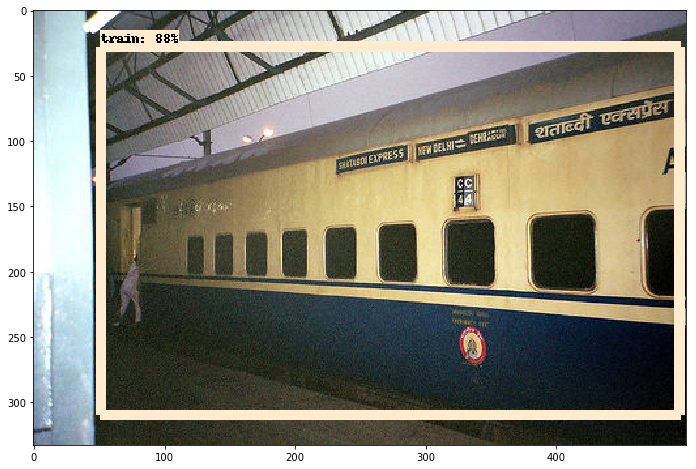

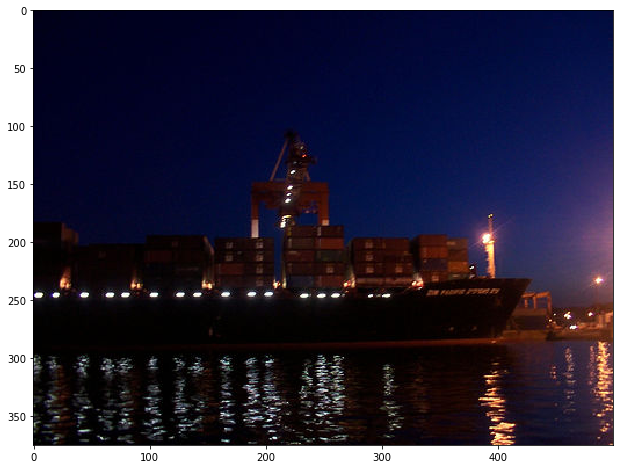

In [17]:
run_detection(images[:2], annotations[:2], True)